ALUNOS: DANIEL CHAVES ALCANTARA / FELIPE SOUSA NOGUEIRA

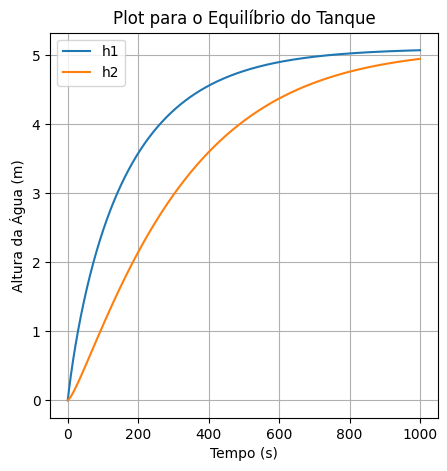


Matriz A:
[[-0.004905  0.      ]
 [ 0.004905 -0.004905]]

Matriz B:
[[0.05 0.  ]
 [0.   0.05]]

Matriz C:
[[0 1]]

Matriz D:
[[0 0]]

Função de Transferência (Antes da Simplificação):
G(s) = (0.00024525*s^0) / (2.4059e-05*s^0 + 0.00981*s^1 + 1*s^2)


In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.signal import ss2tf, lsim, StateSpace
import sympy as sy  
import control as ctrl 
import control.matlab as ctrlmatlab  

g = 9.81  # Aceleração da gravidade (m/s^2)
A1 = 20  # Área do tanque 1 (m^2)
A2 = 20  # Área do tanque 2 (m^2)
a1 = 0.1  # Área do orifício entre tanque 1 e tanque 2 (m^2)
a2 = 0.1  # Área do orifício de saída do tanque 2 (m^2)
Q1 = 1    # Vazão de entrada no tanque 1 (m^3/s)
Q2 = 0    # Vazão de entrada no tanque 2 (m^3/s)


def ponto_operacao(x):
    h1, h2 = x
    eq1 = Q1 - a1 * np.sqrt(2 * g * h1)
    eq2 = Q2 + a1 * np.sqrt(2 * g * h1) - a2 * np.sqrt(2 * g * h2)
    return [eq1, eq2]


estimativa_inicial = [5, 5]  
h1_op, h2_op = fsolve(ponto_operacao, estimativa_inicial)


def tanques(x, t, Q1, Q2, A1, A2, a1, a2):
    h1 = x[0]
    h2 = x[1]
    dh1_dt = (Q1 - a1 * np.sqrt(2 * g * h1)) / A1
    dh2_dt = (Q2 + a1 * np.sqrt(2 * g * h1) - a2 * np.sqrt(2 * g * h2)) / A2
    return [dh1_dt, dh2_dt]


t = np.linspace(0, 1000, 2500)

#Resolver a EDO para simulação com as condições iniciais
initial_conditions = [0, 0]
solution = odeint(tanques, initial_conditions, t, args=(Q1, Q2, A1, A2, a1, a2))
h1_sol = solution[:, 0]
h2_sol = solution[:, 1]

plt.figure(figsize=(5, 5))
plt.plot(t, h1_sol, label='h1')
plt.plot(t, h2_sol, label='h2')
plt.xlabel('Tempo (s)')
plt.ylabel('Altura da Água (m)')
plt.title('Plot para o Equilíbrio do Tanque')
plt.legend()
plt.grid(True)
plt.show()


A = np.array([
    [-(a1 * np.sqrt(2 * g)) / (2 * A1 * np.sqrt(h1_op)), 0],
    [(a1 * np.sqrt(2 * g)) / (2 * A2 * np.sqrt(h1_op)), -(a2 * np.sqrt(2 * g)) / (2 * A2 * np.sqrt(h2_op))]
])

B = np.array([
    [1 / A1, 0],
    [0, 1 / A2]
])

C = np.array([[0, 1]])  
D = np.array([[0, 0]])

# Exibir as matrizes de espaço de estado
print("\nMatriz A:")
print(A)

print("\nMatriz B:")
print(B)

print("\nMatriz C:")
print(C)

print("\nMatriz D:")
print(D)


B_single_input = B[:, 0].reshape(-1, 1)
D_single_input = D[:, 0].reshape(-1, 1)


num, den = ss2tf(A, B_single_input, C, D_single_input)

print("\nFunção de Transferência (Antes da Simplificação):")
numerador_str = " + ".join([f"{coef:.5g}*s^{i}" for i, coef in enumerate(num[0][::-1]) if coef != 0])
denominador_str = " + ".join([f"{coef:.5g}*s^{i}" for i, coef in enumerate(den[::-1]) if coef != 0])
print(f"G(s) = ({numerador_str}) / ({denominador_str})")



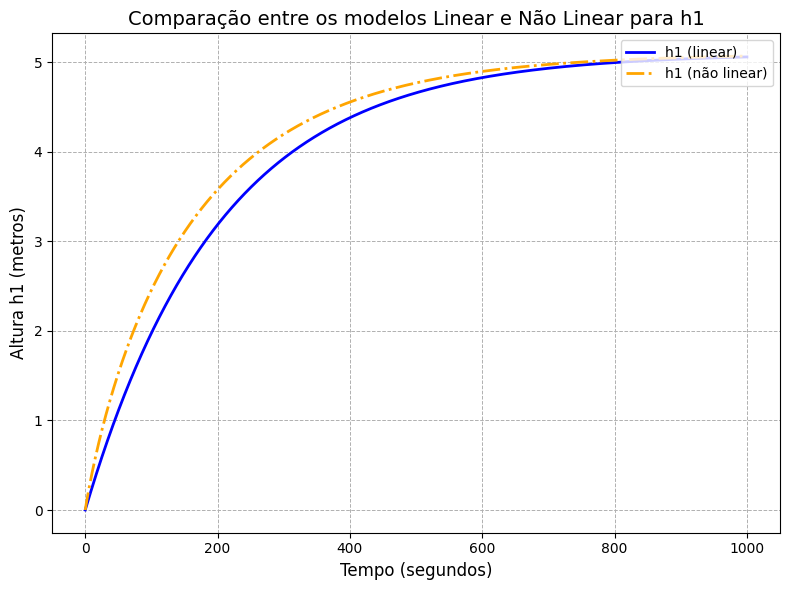

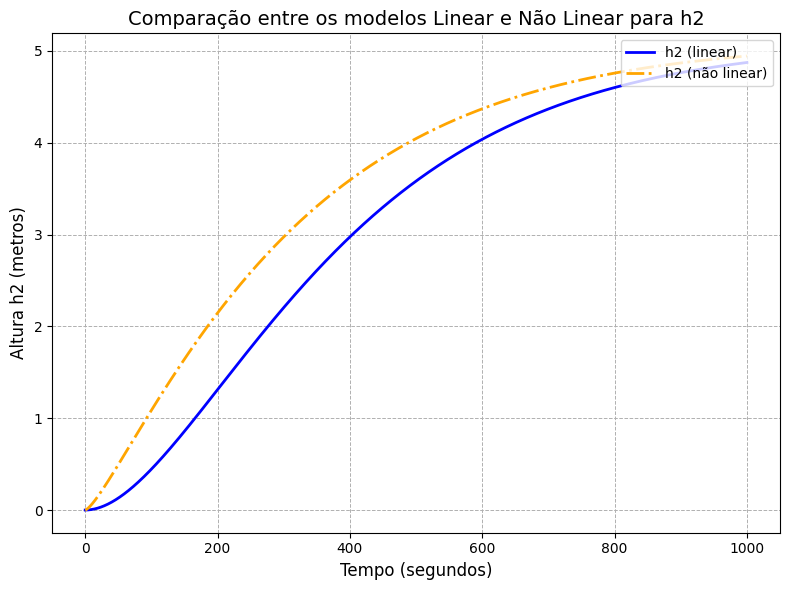

In [2]:
#Alturas de equilíbrio dos tanques
heq1 = h1_op  
heq2 = h2_op  

h_1 = sy.Symbol('h_1')
h_2 = sy.Symbol('h_2')
Q_1 = sy.Symbol('Q_1')
Q_2 = sy.Symbol('Q_2')

#Equações não lineares de saída
Vsaida1 = a1 * sy.sqrt(2 * 10 * h_1)
Vsaida2 = a2 * sy.sqrt(2 * 10 * h_2)

dh1 = (Q_1 - Vsaida1) / A1
dh2 = (Q_2 + Vsaida1 - Vsaida2) / A2

campo_sistema = sy.Matrix([dh1, dh2])

#matrizes Jacobianas
matrizAjacobiana = campo_sistema.jacobian([h_1, h_2])
matrizBjacobiana = campo_sistema.jacobian([Q_1, Q_2])

#Avaliação das Jacobianas nos pontos de equilíbrio
subs_eq = {h_1: heq1, h_2: heq2, Q_1: Q1, Q_2: Q2}
A_eq = matrizAjacobiana.evalf(subs=subs_eq)
B_eq = matrizBjacobiana.evalf(subs=subs_eq)

A_lin = np.asarray(A_eq, dtype=np.float64)
B_lin = np.asarray(B_eq, dtype=np.float64)


#Modelo linear 
modelo_linear_tanque = ctrl.ss(A, B, C, D)

#Simulação do sistema linearizado
A = 1
entrada = np.zeros((len(t), 2))  * A
resposta_saida, tempo_resposta, estados = ctrlmatlab.lsim(
    modelo_linear_tanque, entrada, t, initial_conditions - np.array([heq1, heq2])
)

#Ajuste dos resultados para os valores de equilíbrio
altura_tanque1 = estados[:, 0] + heq1
altura_tanque2 = estados[:, 1] + heq2

#Plot comparativo entre os modelos linear e não linear para h1
plt.figure(figsize=(8, 6))  
plt.plot(t, altura_tanque1, color='blue', linestyle='-', linewidth=2, label='h1 (linear)')
plt.plot(t, h1_sol, color='orange', linestyle='-.', linewidth=2, label='h1 (não linear)')
plt.ylabel('Altura h1 (metros)', fontsize=12)
plt.xlabel('Tempo (segundos)', fontsize=12)
plt.title('Comparação entre os modelos Linear e Não Linear para h1', fontsize=14)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.7)
plt.tight_layout()  
plt.show()

#Plot comparativo entre os modelos linear e não linear para h2
plt.figure(figsize=(8, 6))  # Ajuste do tamanho da figura
plt.plot(t, altura_tanque2, color='blue', linestyle='-', linewidth=2, label='h2 (linear)')
plt.plot(t, h2_sol, color='orange', linestyle='-.', linewidth=2, label='h2 (não linear)')
plt.ylabel('Altura h2 (metros)', fontsize=12)
plt.xlabel('Tempo (segundos)', fontsize=12)
plt.title('Comparação entre os modelos Linear e Não Linear para h2', fontsize=14)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.7)
plt.tight_layout()  
plt.show()


PARTE 2

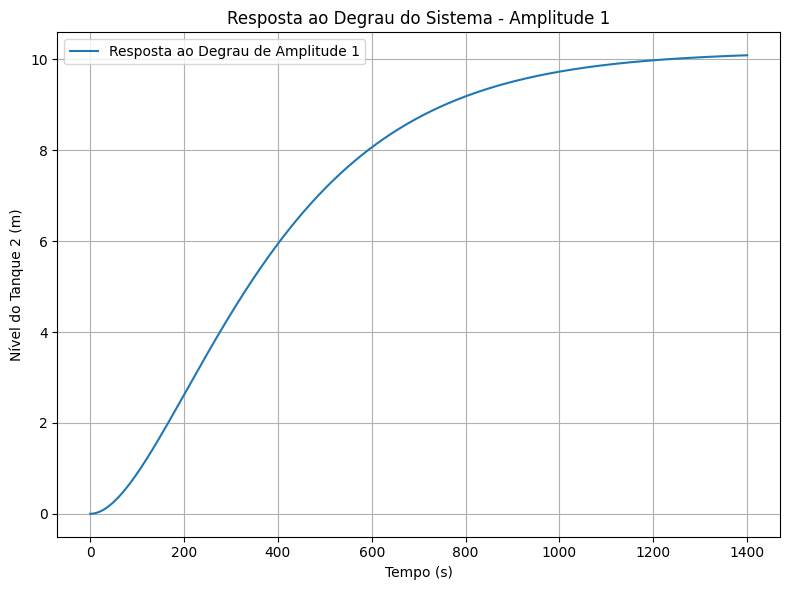

In [3]:
#Definindo a função de transferência após o cálculo com as matrizes de espaço de estado.
numerador = [0.00024525]
denominador = [1, 2 * 0.00491, 0.00491**2]

# Criar a função de transferência G(s)
G = ctrl.tf(numerador, denominador)

# Definir a amplitude do degrau
A = 1  

t, y_out = ctrl.step_response(A * G, T=np.linspace(0, 1400, 1000))

# Plotar a resposta ao degrau
plt.figure(figsize=(8, 6))
plt.plot(t, y_out, label=f'Resposta ao Degrau de Amplitude {A}')
plt.xlabel('Tempo (s)')
plt.ylabel('Nível do Tanque 2 (m)')
plt.title(f'Resposta ao Degrau do Sistema - Amplitude {A}')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
#valor de estado estacionário
valor_final = y_out[-1]

# Overshoot
valor_maximo = np.max(y_out)
overshoot = ((valor_maximo - valor_final) / valor_final) * 100

#Tempo de subida
rise_time_indices = np.where((y_out >= 0.1 * valor_final) & (y_out <= 0.9 * valor_final))[0]
tempo_subida = t[rise_time_indices[-1]] - t[rise_time_indices[0]]

#tempo de estabilização
tolerancia = 0.02 * valor_final
tempo_estabilizacao_indices = np.where(np.abs(y_out - valor_final) <= tolerancia)[0]
tempo_estabilizacao = t[tempo_estabilizacao_indices[0]] if len(tempo_estabilizacao_indices) > 0 else np.inf

print(f"Valor de estado estacionário: {valor_final:.4f} m")
print(f"Porcentagem de Overshoot: {overshoot:.2f}%")
print(f"Tempo de subida (10% a 90%): {tempo_subida:.2f} s")
print(f"Tempo de estabilização (2%): {tempo_estabilizacao:.2f} s")

Valor de estado estacionário: 10.0901 m
Porcentagem de Overshoot: 0.00%
Tempo de subida (10% a 90%): 665.67 s
Tempo de estabilização (2%): 1108.51 s


Polos do sistema:
Polo: -0.00491+0.00000j
Polo: -0.00491-0.00000j


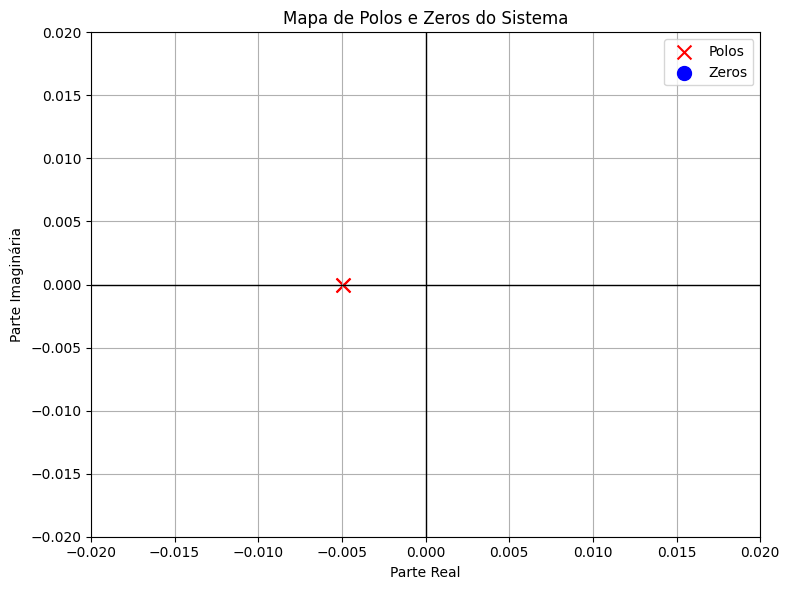

In [5]:
# Encontrar os zeros (raízes do numerador)
zeros = np.roots(numerador)

# Encontrar os polos (raízes do denominador)
polos = np.roots(denominador)

# Exibir os polos e zeros
print("Polos do sistema:")
for p in polos:
    print(f"Polo: {p:.5f}")


plt.figure(figsize=(8, 6))
plt.scatter(np.real(polos), np.imag(polos), marker='x', color='red', s=100, label='Polos')
plt.scatter(np.real(zeros), np.imag(zeros), marker='o', color='blue', s=100, label='Zeros')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)

plt.xlim([-0.02, 0.02])  
plt.ylim([-0.02, 0.02])  

plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginária')
plt.title('Mapa de Polos e Zeros do Sistema')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

PARTE 3

Kp: 10.19369051082755
Ki: 0.44144954128440367
Ti: 407.33197556008145


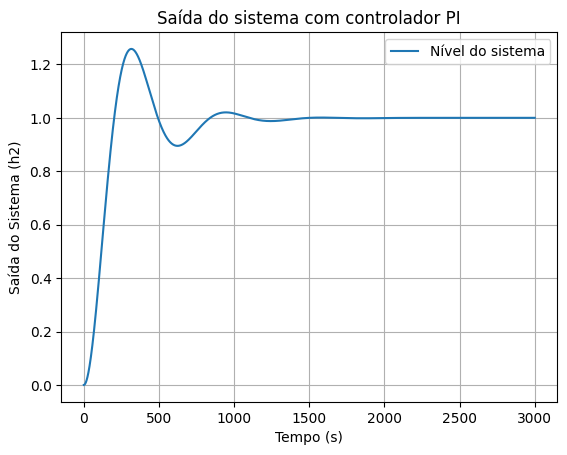

Erro de estado estacionário do sistema com o controlador PI: 0.01


In [6]:
# Função de transferência obtida
num_sys = [0.00024525]
den_sys = [1, 0.00981, 0.000024059]
G = ctrl.tf(num_sys, den_sys)

# Calculamos Kp
Kp = num_sys[0]/den_sys[-1]
print(f"Kp: {Kp}")

err = 0.1 # Erro desejado

# Calculamos o ganho integrativo para o controlador PI
Ki = (1 - err) / (err * Kp) / 2  
print(f"Ki: {Ki}")

# Calculamos Ti
Ti = 2 / (0.00491) 
print(f"Ti: {Ti}")

# Criamos a função de transferência do controlador
PI = ctrl.tf([Ki * Ti, Ki], [Ti, 0])
Sis_Controlado = PI * G

# Fechamos a malha com o controlador PI
T2 = ctrl.feedback(Sis_Controlado, 1) 

# Plotamos a resposta ao degrau
t = np.linspace(0, 3000, 10000)  
t2, y2 = ctrl.step_response(T2, T=t)  

# Plotando a resposta ao degrau do sistema com controlador PI
plt.figure()
plt.plot(t2, y2, label='Nível do sistema')
# Adicionando rótulos e título
plt.title('Saída do sistema com controlador PI')
plt.xlabel('Tempo (s)')
plt.ylabel('Saída do Sistema (h2)')
plt.grid(True)
plt.legend()
plt.show()

#Valor esperado
err2 = (1 - y2[-1]) * 100
print(f"Erro de estado estacionário do sistema com o controlador PI: {err2:.2f}")


Kp: 10.19369051082755
Ki: 0.44144954128440367
Ti: 407.33197556008145


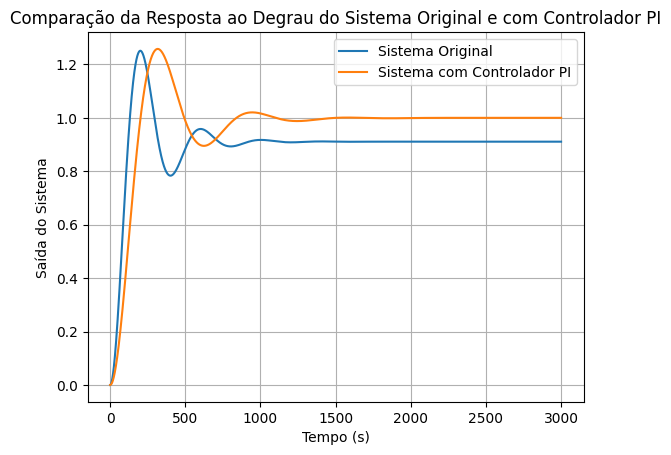

Erro de estado estacionário do sistema com o controlador PI: 0.01%
Valor de estabilização do sistema original:0.91
Valor de estabilização do sistema com controle: 1.00


In [7]:
# Função de transferência obtida
num_sys = [0.00024525]
den_sys = [1, 0.00981, 0.000024059]
G = ctrl.tf(num_sys, den_sys)

# Calculamos Kp
Kp = num_sys[0]/den_sys[-1]
print(f"Kp: {Kp}")

err = 0.1 # Erro desejado

# Calculamos o ganho integrativo para o controlador PI
Ki = (1 - err) / (err * Kp) / 2  
print(f"Ki: {Ki}")

# Calculamos Ti
Ti = 2 / (0.00491) 
print(f"Ti: {Ti}")

# Criamos a função de transferência do controlador
PI = ctrl.tf([Ki * Ti, Ki], [Ti, 0])
Sis_Controlado = PI * G

# Simulamos o sistema original com malha fechada
T1 = ctrl.feedback(G, 1)  # Sistema original
T2 = ctrl.feedback(Sis_Controlado, 1) 

# Criamos a simulação
t = np.linspace(0, 3000, 10000)  
t1, y1 = ctrl.step_response(T1, T=t)  # Sistema original
t2, y2 = ctrl.step_response(T2, T=t)  # Sistema com controlador PI

# Plotando ambas as respostas ao degrau no mesmo gráfico
plt.figure()
plt.plot(t1, y1, label='Sistema Original')
plt.plot(t2, y2, label='Sistema com Controlador PI')
plt.title('Comparação da Resposta ao Degrau do Sistema Original e com Controlador PI')
plt.xlabel('Tempo (s)')
plt.ylabel('Saída do Sistema')
plt.grid(True)
plt.legend()
plt.show()

# Valor desejado:
err2 = (1 - y2[-1]) * 100
print(f"Erro de estado estacionário do sistema com o controlador PI: {err2:.2f}%")

print(f"Valor de estabilização do sistema original:{y1[-1]:.2f}")
print(f"Valor de estabilização do sistema com controle: {y2[-1]:.2f}")